# OPTIMAL TRANSPORT COURSE - Final Project


---

This notebook presents the final project of the course. It was produced by Oscar Bouvier and Thomas Jacquot.

The main objective is to implement an *OT GAN*-algorithm as described in the following article : 
> *Tim Salimans and Han Zhang and Alec Radford and Dimitris Metaxas* (2018), [Improving GANs Using Optimal Transport](https://openreview.net/pdf?id=rkQkBnJAb)

We have also implemented 2 other GANs (BasicGAN and DCGAN) that are used as benchmark models. 

For this work we will use a simple dataset as the MNIST one. 

# Packages et useful configurations

In [ ]:
#To load the dataset
from keras.datasets import mnist
#Classical packages 
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
#Pytorch 
import torch
from torch import nn, tensor, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image, resize, to_tensor
from torchvision.transforms.functional import normalize
# GPU configuration
from multiprocessing import cpu_count
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
from time import time


# Models

In this part, we define functions and class that will be used to execute Basic, DCGAN and OT-GAN algorithms. The first function will allow us to display the images on the notebook. 

In [ ]:
def display(images, row=2, col=10):
    fig = plt.figure(figsize=(20, 3))
    it = 0
    for r in range(row):
        for c in range(col):
            ax = plt.subplot(row, col, it + 1)
            ax.set_axis_off()
            ax.imshow((images[it, :, :, :].reshape((28, 28)) * 0.5 + 0.5), cmap='gray')
            it += 1

    plt.show()

## Basic GAN Generator and Discriminator

In [ ]:
#Define the Generator class of the  Basic GAN 
class Generator(nn.Module):

  def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, image_size, image_shape):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size_1)
    self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
    self.fc4 = nn.Linear(hidden_size_3, image_size)

    self.activation = nn.LeakyReLU(negative_slope=0.2)
    self.image_shape = image_shape

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    x = self.activation(self.fc3(x))
    x = torch.tanh(self.fc4(x))

    return torch.reshape(x, (-1, ) + self.image_shape)

In [ ]:
#Define the Dicriminator class of the Basic GAN 
class Discriminator(nn.Module):

  def __init__(self, image_size, hidden_size_1, hidden_size_2, hidden_size_3):
    super(Discriminator, self).__init__()
    self.flatten = nn.Flatten(1, -1)
    self.fc1 = nn.Linear(image_size, hidden_size_1)
    self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
    self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
    self.fc4 = nn.Linear(hidden_size_3, 1)

    self.activation = nn.LeakyReLU(0.2)  
    
  def forward(self, x):

    x = self.flatten(x)
    x = self.activation(self.fc1(x))
    x = F.dropout(x, 0.3)

    x = self.activation(self.fc2(x))
    x = F.dropout(x, 0.3)

    x = self.activation(self.fc3(x))
    x = F.dropout(x, 0.3)

    x = F.sigmoid(self.fc4(x))

    return x

## DCGAN Generator and Discriminator

In [ ]:
#Define the Generator class of the DCGAN
class DC_Generator(nn.Module):
  """Deep Convolutional image generator for DC GAN"""

  def __init__(self, input_size, image_shape):
    super(DC_Generator, self).__init__()

    self.input_size = input_size
    self.fc = nn.Linear(self.input_size, 256 * 7 * 7)

    #First convolutional layer -> input : (256, 7, 7), output : (128, 14, 14)
    self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.trans_conv1_bn = nn.BatchNorm2d(128)

    #Second convolutional layer -> input : (128, 14, 14), output : (64, 14, 14)
    self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv2_bn = nn.BatchNorm2d(64)

    #Third convolutional layer -> input : (64, 14, 14), output : (32, 14, 14)
    self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv3_bn = nn.BatchNorm2d(32)

    #Fourth convolutional layer -> input : (32, 14, 14), output : (1, 28, 28)
    self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

  def forward(self, x):

    x = self.fc(x)

    #Reshaping input
    x = x.view(-1, 256, 7, 7)

    x = F.relu(self.trans_conv1(x))
    x = self.trans_conv1_bn(x)

    x = F.relu(self.trans_conv2(x))
    x = self.trans_conv2_bn(x)

    x = F.relu(self.trans_conv3(x))
    x = self.trans_conv3_bn(x)

    x = self.trans_conv4(x)

    return torch.tanh(x)

In [ ]:
#Defin the Discriminator class of the DCGAN
class DC_Discriminator(nn.Module):
    """Deep Convolutional image discriminator for DC GAN"""
    
    def __init__(self):
        super(DC_Discriminator, self).__init__()

        #First convolutional layer -> input : (1, 28, 28), output : (32, 14, 14)
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)

        #Second convolutional layer -> input : (32, 14, 14), output : (64, 14, 14)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.25)

        #Third convolutional layer -> input : (64, 14, 14), output : (128, 14, 14)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.25)
        
        #Fourth convolutional layer -> input : (128, 14, 14), output : (256, 7, 7)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.25)

        #Fully connected layer to get discriminator decision
        self.fc = nn.Linear(256 * 7 * 7, 1)
    
    def forward(self, x):
        
        #Reshaping data
        x = x.view(-1, 1, 28, 28)
        
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_bn(x)
        x = self.conv0_drop(x)

        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_bn(x)
        x = self.conv1_drop(x)

        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_bn(x)
        x = self.conv2_drop(x)

        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_bn(x)
        x = self.conv3_drop(x)

        #Flattening before fully connected pass
        x = x.view(-1, 7 * 7 * 256)
        x = self.fc(x)
        
        return torch.sigmoid(x)

## OTGAN Generator and Discriminator

In [ ]:
#Define the Generator class of the OT-GAN
class OT_Generator(nn.Module):
    
    def __init__(self, input_size, kernel_size=5):
        super(OT_Generator, self).__init__()

        self.fc = nn.Linear(input_size, 2 * 512 * 7 * 7)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        conv_padding_size = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(512, 2 * 256, stride = 1, kernel_size=kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(256, 2 * 128, stride = 1, kernel_size=kernel_size, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(128, 1, stride = 1, kernel_size=kernel_size, padding=conv_padding_size)

    def forward(self, x):

        #Fully connected layer -> input : (batch, latent_dim), output : (batch, 2 * 512 * 7 * 7)
        x = self.fc(x) 
        
        # GLU activation function -> output : (batch, 512 * 7 * 7)
        x, l = torch.split(x, 512 * 7 * 7, 1)
        x *= torch.sigmoid(l)

        #Reshaping -> output : (batch, 512, 7, 7)
        x = x.view(-1, 512, 7, 7)

        #Upsampling layer -> output : (batch, 512, 14, 14)
        x = self.upsample(x) 

        #First conv layer -> output : (batch, 2 * 256, 14, 14)
        x = self.conv1(x)

        #GLU activation function -> output : (batch, 256, 14, 14)
        x, l = torch.split(x, 256, 1)
        x *= torch.sigmoid(l)

        #Upsampling layer -> output : (batch, 256, 28, 28)
        x = self.upsample(x)

        #Second conv layer -> output : (batch, 2 * 128, 28, 28)
        x = self.conv2(x)

        # GLU activation function -> output : (batch, 128, 28, 28)
        x, l = torch.split(x, 128, 1)
        x *= torch.sigmoid(l)

        x = self.conv3(x)

        #Third conv layer -> output : (batch, 1, 28, 28)
        x = torch.tanh(x) 

        return x

In [ ]:
#Define the Discriminator class of the OT-GAN
class OT_Discriminator(nn.Module):
    
    def __init__(self, kernel_size=5):
        super(OT_Discriminator, self).__init__()

        conv_padding_size = (kernel_size - 1) // 2

        self.conv1 = nn.Conv2d(1, 64, kernel_size, padding=conv_padding_size)
        self.conv2 = nn.Conv2d(128, 128, kernel_size, stride=2, padding=conv_padding_size)
        self.conv3 = nn.Conv2d(256, 256, kernel_size, stride=2, padding=conv_padding_size)

    def forward(self, x):

        # Shape -> input: (batch, 1, 28, 28), output : (batch, 64, 28, 28)
        x = self.conv1(x) 

        # CReLU -> output : (batch, 128, 28, 28)
        x = torch.cat((F.relu(x), F.relu(-x)), 1)
        
        # Shape -> output : (batch, 128, 14, 14)
        x = self.conv2(x) 

        #CReLU -> output : (batch, 256, 14, 14)
        x = torch.cat((F.relu(x), F.relu(-x)), 1)

        #Shape -> output : (batch, 256, 7, 7)
        x = self.conv3(x)

        #CReLU -> output : (batch, 512, 7, 7)
        x = torch.cat((F.relu(x), F.relu(-x)), 1)

        #Flattening -> output : (batch, 25088)
        x = nn.Flatten()(x)

        x = F.normalize(x, dim=1, p=2)

        return x 

## OTGAN

In [ ]:
class DoubleBatchDataset(data.Dataset):
    def __init__(self, data1, data2):
        self.data1 = data1
        self.data2 = data2

    def __len__(self):
        return self.data1.shape[0]

    def __getitem__(self, index):
        return self.data1[index], self.data2[index]

In [ ]:
class OTGAN():

    def __init__(self, generator, critic, latent_dim, g_to_c_ratio=3, lr=0.0003):

        self.latent_dim = latent_dim
        self.lr = lr
        self.generator = generator.to(device)
        self.critic = critic.to(device)

    def sample_data(self, n_sample):
        z = torch.randn(n_sample, self.latent_dim).to(device)
        samples = self.generator(z)
        samples = samples.detach().cpu().numpy()
        return samples

    def cost(self, batch_1, batch_2):
        dot = batch_1 @ batch_2.t()
        return 1 - dot

    def sinkhorn_plan(self, a, b, C, reg=1, max_iters=100):
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)

        with torch.no_grad():
            K = torch.exp(-C/reg)
            for i in range(max_iters):
                u = a / (torch.matmul(K,v) + 1e-8)
                v = b / (torch.matmul(K.T,u) + 1e-8)

        M = torch.matmul(torch.diag(u), torch.matmul(K, torch.diag(v)))

        return M

    def sinkhorn_distance(self, sinkhorn_plan, C):
        return torch.sum(sinkhorn_plan * C)

        
    def train(self, data, batch_size=100, n_epochs=100, print_interval=1):
        
        critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(0.5, 0.999))
        generator_optimizer = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.5, 0.999))
        
        data = data.view(-1, 1, 28, 28)
        data_shuffled = data[torch.randperm(data.shape[0])]
        double_data = DoubleBatchDataset(data, data_shuffled)
        dataloader = torch.utils.data.DataLoader(double_data, batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_epochs + 1):
            
            t=time()

            for i, (X_batch1, X_batch2) in tqdm(enumerate(dataloader)):
                
                batch_size = X_batch1.shape[0]

                self.critic.zero_grad()
                self.generator.zero_grad()
    
                real_1 = X_batch1.type(torch.FloatTensor).to(device)
                real_2 = X_batch2.type(torch.FloatTensor).to(device)
                
                #z1 = self.uniform_m1_1((batch_size, self.latent_dim)).to(device)
                z1 = torch.randn(batch_size, latent_dim).to(device)
                fake_1 = self.generator(z1)

                #z2 = self.uniform_m1_1((batch_size, self.latent_dim)).to(device)
                z2 = torch.randn(batch_size, latent_dim).to(device)
                fake_2 = self.generator(z2)
                
                critic_real_1 = self.critic(real_1)
                critic_real_2 = self.critic(real_2)
                critic_fake_1 = self.critic(fake_1)
                critic_fake_2 = self.critic(fake_2)

                # Computing all matrices of costs

                costs = torch.zeros((4, 4, batch_size, batch_size)).to(device)

                costs[0,1] = self.cost(critic_real_1, critic_real_2)
                costs[0,2] = self.cost(critic_real_1, critic_fake_1)
                costs[0,3] = self.cost(critic_real_1, critic_fake_2)
                costs[1,2] = self.cost(critic_real_2, critic_fake_1)
                costs[1,3] = self.cost(critic_real_2, critic_fake_2)
                costs[2,3] = self.cost(critic_fake_1, critic_fake_2)

                # Computing optimal plans for all costs

                a = (torch.ones(batch_size) / batch_size).to(device)
                b = (torch.ones(batch_size) / batch_size).to(device)

                # Computing losses
                distances = torch.zeros((4,4)).to(device)
                
                distances[0,1] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 1]),  costs[0, 1])
                distances[0,2] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 2]),  costs[0, 2])
                distances[0,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 3]),  costs[0, 3])
                distances[1,2] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[1, 2]),  costs[1, 2])
                distances[1,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[1, 3]),  costs[1, 3])
                distances[2,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[2, 3]),  costs[2, 3])  
                
                loss = (distances[0,2] + distances[0,3] + distances[1,2] + distances[1,3] -
                        2 * distances[0,1] - 2 * distances[2,3])
                                
                loss.backward()
                generator_optimizer.step()

                if i+1 % 3 == 0:
                    critic_optimizer.step()
                else:
                    generator_optimizer.step()
   
              
            if (epoch * 3)% print_interval == 0 :
                print(f'Epoch : {epoch}, Iteration : {i}')
                samples = self.sample_data(20)*0.5 + 0.5
                display(samples)

            train_loss = loss.detach().cpu().numpy()
            print("Epoch %s: loss = %s;  time = %s" %(epoch, train_loss, time()-t))


# Data presentation

[MNIST](http://yann.lecun.com/exdb/mnist/) is a famous handwritten digit dataset. It is composed of a test sample of size 60 000 and a test sample of size 10 000. Since it is often used in Machine Learning litterature, we have choosen to implement the OT-GAN on this dataset. You will find below an overview of the data : 

11493376/11490434 [==============================] - 0s 0us/step


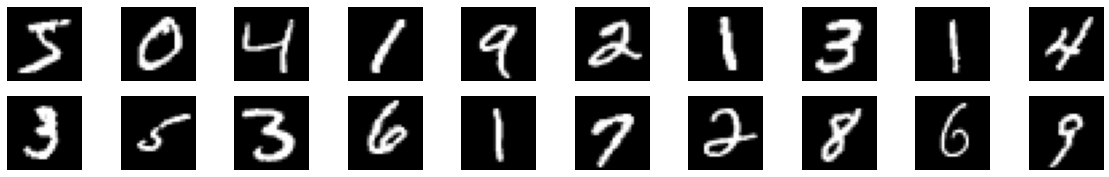

In [ ]:
#Load data from keras datasets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#Resize it 
X_train = (X_train - 127.5)/ 127.5
X_train = np.reshape(X_train, (-1, 28, 28, 1))
#Display the images 
display(X_train)

# Basic GAN and DCGAN

Before implementing the OT-GAN discribed in the article, we will first use the most used algorithms : 

In [ ]:
x_train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()

## GAN

In [ ]:
class GAN:
  '''
  Runs a GAN. 
  :parameters
    :param data: torch.Tensor - pytroch tensor of size ([., 28, 28, 1])
    :param latent_dim : int - number of samples used 
    :param batch_size: int - indicates the batch size 
    :param lr : float - learning rate for gradient descent 
    :param epochs: int - number of epochs 
  '''

  def __init__(self, generator, discriminator, latent_dim = 100):

    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim


  def sample_data(self, n_sample):
    z = torch.randn(n_sample, latent_dim).to(device)
    samples = self.generator(z)
    samples = samples.detach().cpu().numpy()
    
    return samples
    

  def train(self, data, batch_size = 100, lr = 2 * 1e-4, epochs=30):
    data_loader = DataLoader(data, batch_size = batch_size, shuffle=True)
      
    #Put Generator and Discriminator on device
    self.generator.to(device)
    self.discriminator.to(device)

    #Define loss function
    criterion = nn.BCELoss()

    #Define solver 
    generator_optimizer = optim.Adam(self.generator.parameters(), lr = lr)
    discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr = lr)

    discriminator_steps = 1
    generator_steps = 1

    for epoch in range(epochs+1):

      t = time()
        
      for i, X_batch in tqdm(enumerate(data_loader)):
          
        for step in range(discriminator_steps):
          
          discriminator.zero_grad()
          X_batch = X_batch.to(device)

          #Discriminator loss on real data
          d_real = discriminator(X_batch)
          d_real = d_real.to(device)

          y_ones = torch.ones(d_real.shape)
          y_ones = y_ones.to(device)

          real_loss_discriminator = criterion(d_real, y_ones)

          #Discriminator loss on fake data
          z = torch.randn(batch_size, self.latent_dim)
          z = z.to(device)

          fake = generator(z).detach() #detach not to update generator parameters wrt to discriminator loss
          d_fake = discriminator(fake)

          y_zeros = torch.zeros(d_fake.shape)
          y_zeros = y_zeros.to(device)

          fake_loss_discriminator = criterion(d_fake, y_zeros)

          #Summing the two losses
          discriminator_loss = real_loss_discriminator + fake_loss_discriminator
            
          discriminator_loss.backward()
          discriminator_optimizer.step()

        for step in range(generator_steps):

          #Generator loss
          generator.zero_grad()

          z = torch.from_numpy(np.random.randn(batch_size, latent_dim)).float()
          z = z.to(device)

          fake_gen = generator(z)
          fake_gen = fake_gen.to(device)

          d_fake_gen = discriminator(fake_gen)
          y_ones = torch.ones((d_fake_gen.shape)).to(device)

          generator_loss = criterion(d_fake_gen, y_ones)

          generator_loss.backward()
          generator_optimizer.step()

      if epoch % 3 == 0:
        print('Epoch %s:  ' %(epoch))
        images = self.sample_data(20).reshape(-1, 28, 28, 1)
        display(images)
        plt.show()
          
      print("Epoch %s: D (%s real_err, %s fake_err); G (%s err); time = %s " %
                            (epoch, real_loss_discriminator.cpu().detach().numpy(), 
                            fake_loss_discriminator.cpu().detach().numpy(),
                            generator_loss.cpu().detach().numpy(), time()-t))

## Running Basic GAN 

*You will find explainations about our implementation and about the Basic GAN architecture in the report*

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 0:  


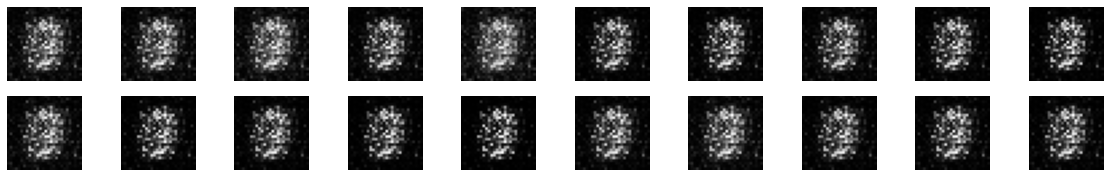

Epoch 0: D (0.6117919 real_err, 0.49252325 fake_err); G (2.4132204 err); time = 7.777029991149902 



Epoch 1: D (0.17969547 real_err, 0.22081226 fake_err); G (2.6698272 err); time = 6.781723737716675 



Epoch 2: D (0.16599856 real_err, 0.17542198 fake_err); G (2.4313786 err); time = 6.6778483390808105 



Epoch 3:  


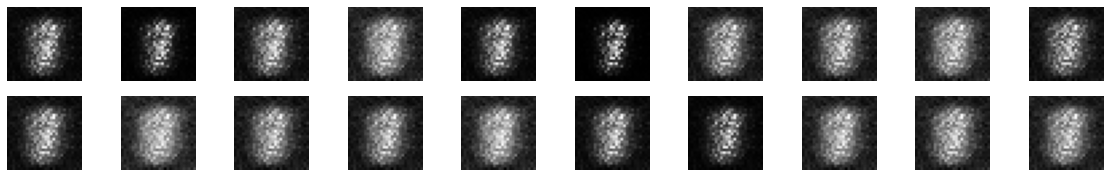

Epoch 3: D (0.10938421 real_err, 0.15335192 fake_err); G (2.5936553 err); time = 7.426093339920044 



Epoch 4: D (0.2814211 real_err, 0.49663988 fake_err); G (2.607925 err); time = 6.725088357925415 



Epoch 5: D (0.1166365 real_err, 0.115730494 fake_err); G (3.264084 err); time = 6.7114808559417725 



Epoch 6:  


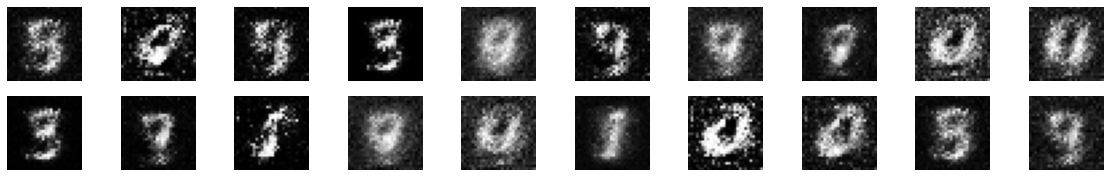

Epoch 6: D (0.43825766 real_err, 0.43683752 fake_err); G (2.250251 err); time = 7.686387300491333 



Epoch 7: D (0.26325926 real_err, 0.39944044 fake_err); G (2.546873 err); time = 6.911294221878052 



Epoch 8: D (0.19082414 real_err, 0.2793068 fake_err); G (2.5242193 err); time = 6.938223838806152 



Epoch 9:  


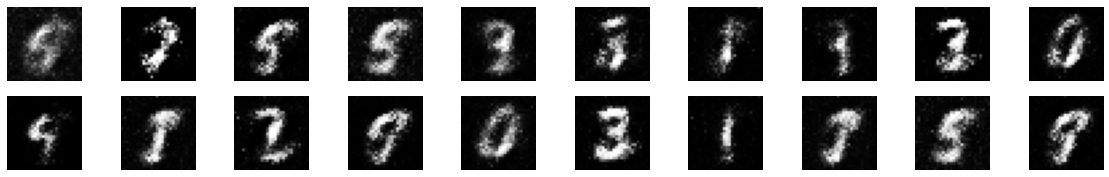

Epoch 9: D (0.6284685 real_err, 0.15844421 fake_err); G (3.0688872 err); time = 7.735623836517334 



Epoch 10: D (0.16314258 real_err, 0.32331863 fake_err); G (2.7718499 err); time = 6.946465015411377 



Epoch 11: D (0.2729044 real_err, 0.38629264 fake_err); G (2.1602373 err); time = 6.954102039337158 



Epoch 12:  


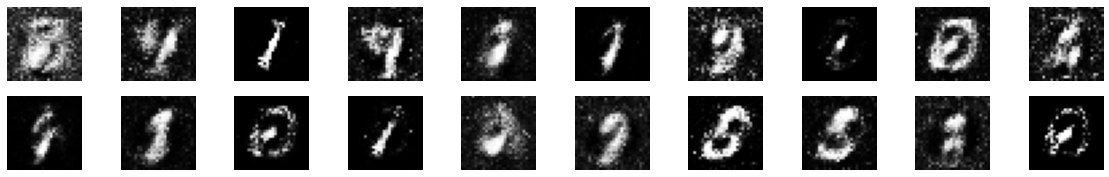

Epoch 12: D (0.38954142 real_err, 0.4429403 fake_err); G (2.401473 err); time = 7.977940320968628 



Epoch 13: D (0.3401702 real_err, 0.97181904 fake_err); G (1.4698503 err); time = 7.258716106414795 



Epoch 14: D (0.2918204 real_err, 0.4392887 fake_err); G (1.8665327 err); time = 7.247860908508301 



Epoch 15:  


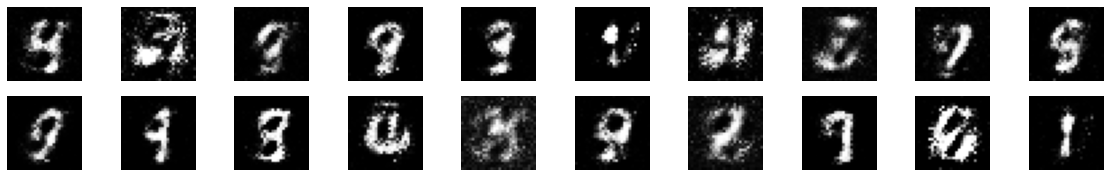

Epoch 15: D (0.53079706 real_err, 0.37054864 fake_err); G (1.7756367 err); time = 7.99307656288147 



Epoch 16: D (0.38450775 real_err, 0.42832476 fake_err); G (1.5478189 err); time = 7.268130540847778 



Epoch 17: D (0.48467696 real_err, 0.46030584 fake_err); G (1.9903837 err); time = 7.173496961593628 



Epoch 18:  


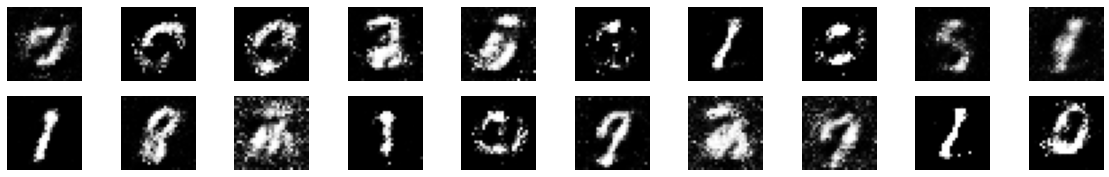

Epoch 18: D (0.2778053 real_err, 0.3677977 fake_err); G (1.9731525 err); time = 8.143198728561401 



Epoch 19: D (0.40424827 real_err, 0.5335447 fake_err); G (1.3820746 err); time = 7.296076774597168 



Epoch 20: D (0.42130557 real_err, 0.5278884 fake_err); G (1.3942108 err); time = 7.40886926651001 



Epoch 21:  


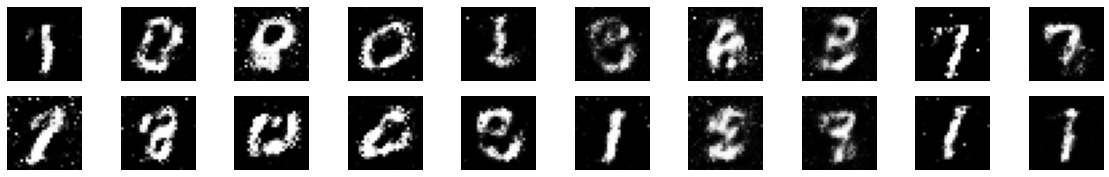

Epoch 21: D (0.5972135 real_err, 0.4898529 fake_err); G (1.4634283 err); time = 8.371567964553833 



Epoch 22: D (0.5091624 real_err, 0.48087004 fake_err); G (1.8510478 err); time = 7.510326623916626 



Epoch 23: D (0.52178 real_err, 0.28547153 fake_err); G (1.5413715 err); time = 7.220381736755371 



Epoch 24:  


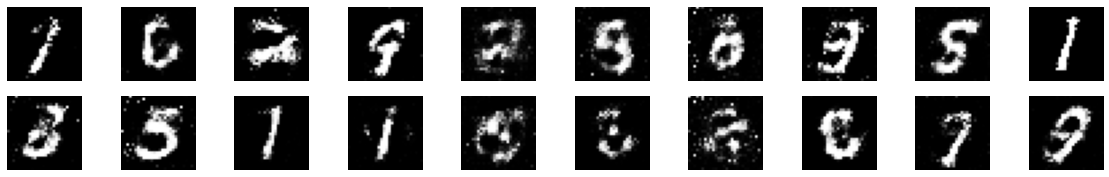

Epoch 24: D (0.5114097 real_err, 0.45309454 fake_err); G (1.5712335 err); time = 8.23650860786438 



Epoch 25: D (0.35230383 real_err, 0.42421213 fake_err); G (1.6057504 err); time = 7.228693723678589 



Epoch 26: D (0.4546001 real_err, 0.36039844 fake_err); G (1.6716098 err); time = 7.16980767250061 



Epoch 27:  


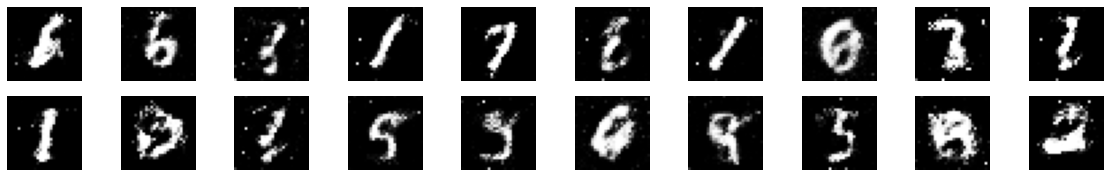

Epoch 27: D (0.7119963 real_err, 0.46285963 fake_err); G (1.4379623 err); time = 8.01611590385437 



Epoch 28: D (0.38981724 real_err, 0.40904918 fake_err); G (1.7191279 err); time = 7.256999731063843 



Epoch 29: D (0.57281286 real_err, 0.5718901 fake_err); G (1.5217352 err); time = 7.2963502407073975 



Epoch 30:  


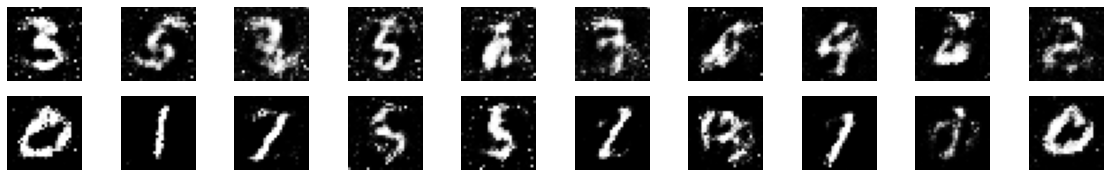

Epoch 30: D (0.691596 real_err, 0.43405193 fake_err); G (1.2061096 err); time = 8.243886947631836 


In [ ]:
#Run Basic GAN on MNIST data

latent_dim = 100
generator = Generator(latent_dim, 256, 512, 1024, 784, (28, 28))
discriminator = Discriminator(784, 1024, 512, 256)

gan = GAN(generator, discriminator, latent_dim)
gan.train(x_train)

## Running DCGAN 

*You will find explainations about our implementation and about the DCGAN architecture in the report*


Epoch 0:  


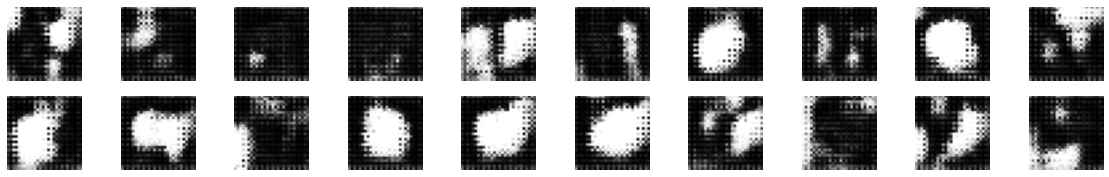

Epoch 0: D (0.0060050115 real_err, 0.00316258 fake_err); G (10.868693 err); time = 51.747841119766235 



Epoch 1: D (0.03982415 real_err, 0.086555995 fake_err); G (4.906134 err); time = 51.01103401184082 



Epoch 2: D (0.7083458 real_err, 0.416694 fake_err); G (3.9563322 err); time = 50.94314789772034 



Epoch 3:  


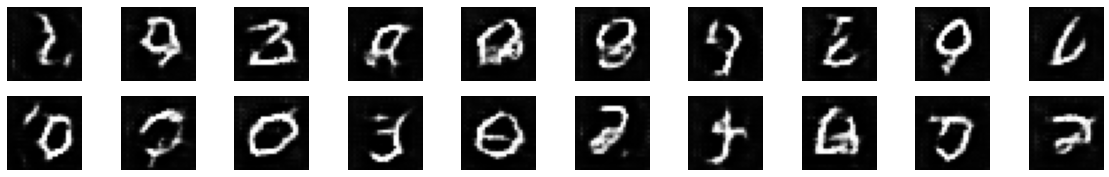

Epoch 3: D (0.16921125 real_err, 0.44399616 fake_err); G (1.7721694 err); time = 51.82535481452942 



Epoch 4: D (0.22853313 real_err, 0.556712 fake_err); G (1.8443885 err); time = 50.77493739128113 



Epoch 5: D (0.42321697 real_err, 0.858702 fake_err); G (1.9033331 err); time = 50.96559143066406 



Epoch 6:  


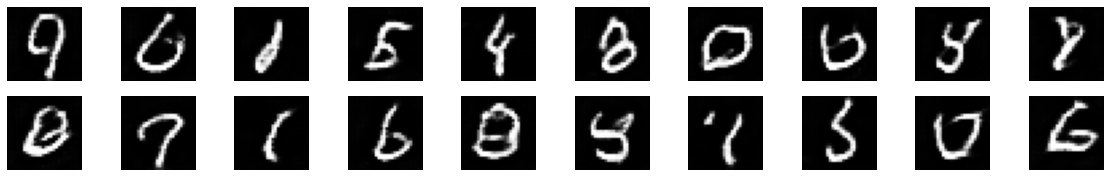

Epoch 6: D (0.6618764 real_err, 0.24571475 fake_err); G (2.294421 err); time = 51.720256090164185 



Epoch 7: D (0.36405388 real_err, 0.39040905 fake_err); G (2.0943286 err); time = 50.97621488571167 



Epoch 8: D (0.5998461 real_err, 1.1271229 fake_err); G (1.1494454 err); time = 50.94980549812317 



Epoch 9:  


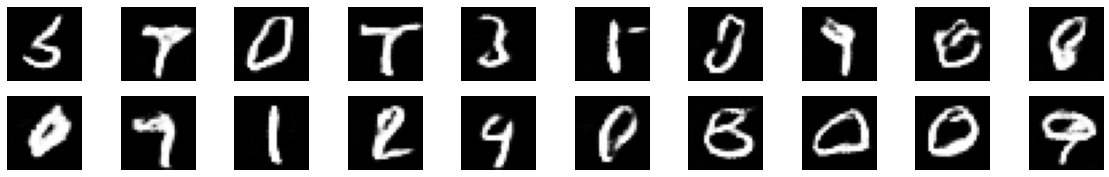

Epoch 9: D (0.18851724 real_err, 1.0908567 fake_err); G (0.91418624 err); time = 51.92420506477356 



Epoch 10: D (0.9513074 real_err, 0.40368807 fake_err); G (1.6096781 err); time = 50.92636179924011 



Epoch 11: D (0.818823 real_err, 0.42237708 fake_err); G (2.3296835 err); time = 51.02006244659424 



Epoch 12:  


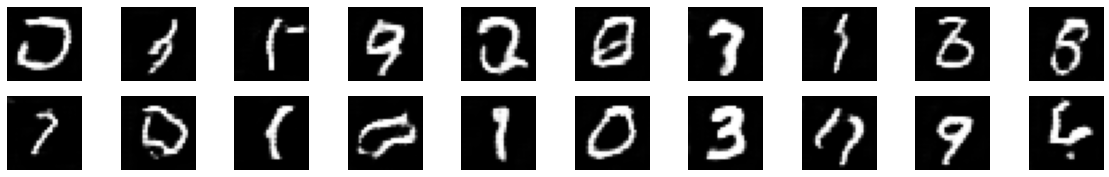

Epoch 12: D (0.5493883 real_err, 0.43072188 fake_err); G (1.9863958 err); time = 51.711973667144775 



Epoch 13: D (0.47734737 real_err, 0.29840615 fake_err); G (2.1416411 err); time = 51.006427526474 



Epoch 14: D (0.5590795 real_err, 0.34666216 fake_err); G (1.6383244 err); time = 51.010772705078125 



Epoch 15:  


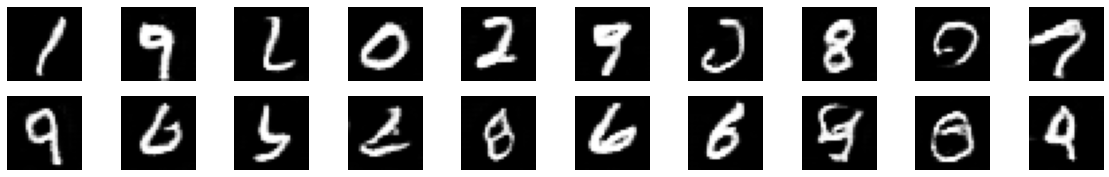

Epoch 15: D (0.62511754 real_err, 0.24983142 fake_err); G (1.9898417 err); time = 51.80189800262451 



Epoch 16: D (0.42514545 real_err, 0.47200128 fake_err); G (1.692306 err); time = 51.017603158950806 



Epoch 17: D (0.22628999 real_err, 0.47931188 fake_err); G (1.7885715 err); time = 50.963207960128784 



Epoch 18:  


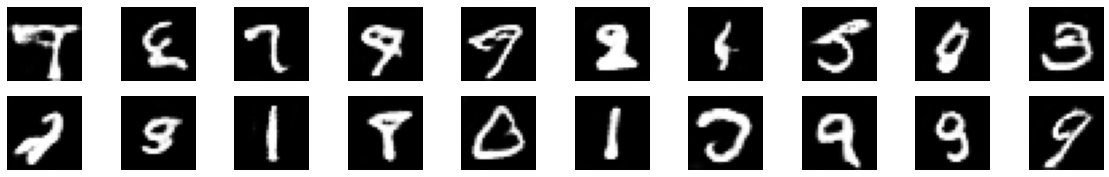

Epoch 18: D (0.4665362 real_err, 0.41041392 fake_err); G (1.3984915 err); time = 52.020490884780884 



Epoch 19: D (0.51317555 real_err, 0.80463547 fake_err); G (1.4963818 err); time = 51.08171010017395 



Epoch 20: D (0.4292189 real_err, 0.9464418 fake_err); G (1.2468686 err); time = 51.05759406089783 



Epoch 21:  


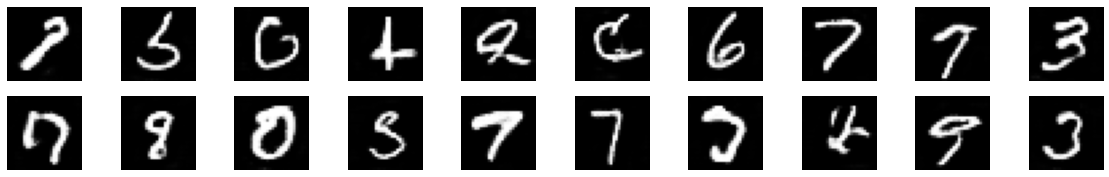

Epoch 21: D (0.4298269 real_err, 0.53299606 fake_err); G (1.4148327 err); time = 51.840219020843506 



Epoch 22: D (0.20200385 real_err, 0.86688846 fake_err); G (1.1932307 err); time = 51.069650411605835 



Epoch 23: D (0.19388126 real_err, 1.2812856 fake_err); G (1.9214312 err); time = 51.11895179748535 



Epoch 24:  


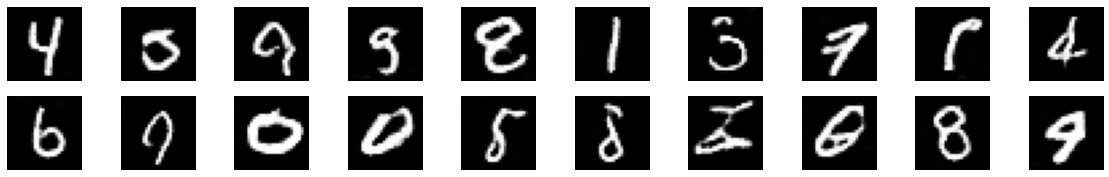

Epoch 24: D (0.34350455 real_err, 0.9019078 fake_err); G (1.5547504 err); time = 52.04666829109192 



Epoch 25: D (0.5475691 real_err, 0.46320185 fake_err); G (0.9379733 err); time = 51.13972878456116 



Epoch 26: D (0.32383507 real_err, 0.8614795 fake_err); G (0.9315477 err); time = 51.051944732666016 



Epoch 27:  


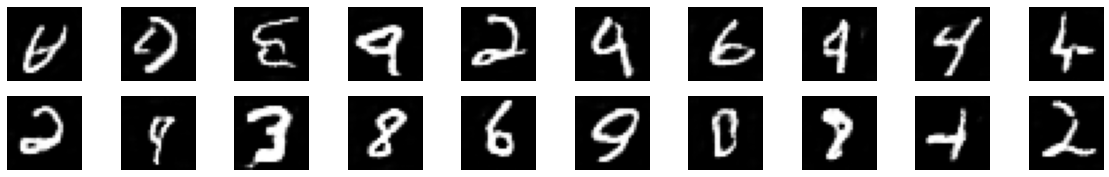

Epoch 27: D (0.50311244 real_err, 0.5476911 fake_err); G (1.4633285 err); time = 51.96378755569458 



Epoch 28: D (0.5771296 real_err, 0.3359931 fake_err); G (1.1791213 err); time = 51.0858256816864 



Epoch 29: D (0.7864512 real_err, 0.39876583 fake_err); G (1.3642187 err); time = 51.05565333366394 



Epoch 30:  


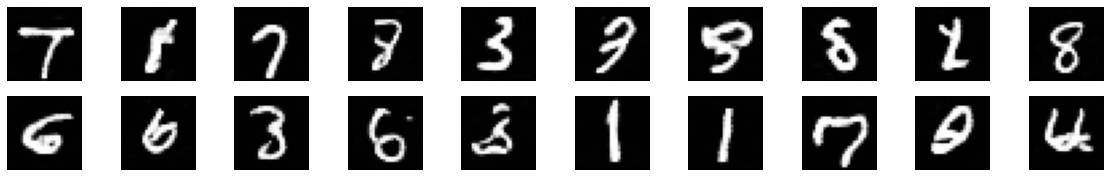

Epoch 30: D (0.39904806 real_err, 0.4759676 fake_err); G (0.8153027 err); time = 52.01534414291382 


In [ ]:
#Run DCGAN on MNIST data

latent_dim = 100

generator = DC_Generator(latent_dim, (28, 28))
discriminator = DC_Discriminator()

gan = GAN(generator, discriminator, latent_dim)
gan.train(x_train)

--- 

# OT-GAN 

*You will find explainations about our implementation and about the OT-GAN architecture in the report*

In [ ]:
class OTGAN():

    def __init__(self, generator, critic, latent_dim):

        self.latent_dim = latent_dim
        self.generator = generator.to(device)
        self.critic = critic.to(device)

    def sample_data(self, n_sample):
        z = torch.randn(n_sample, self.latent_dim).to(device)
        samples = self.generator(z)
        samples = samples.detach().cpu().numpy()
        return samples

    def cost(self, batch_1, batch_2):
        dot = batch_1 @ batch_2.t()
        return 1 - dot

    def sinkhorn_plan(self, a, b, C, reg=1, max_iters=100):
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)

        with torch.no_grad():
            K = torch.exp(-C/reg)
            for i in range(max_iters):
                u = a / (torch.matmul(K,v) + 1e-8)
                v = b / (torch.matmul(K.T,u) + 1e-8)

        M = torch.matmul(torch.diag(u), torch.matmul(K, torch.diag(v)))

        return M

    def sinkhorn_distance(self, sinkhorn_plan, C):
        return torch.sum(sinkhorn_plan * C)

        
    def train(self, data, batch_size=100, lr=3e-4, n_epochs=100, print_interval=100):
        
        critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr, betas=(0.5, 0.999))
        generator_optimizer = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        data = data.view(-1, 1, 28, 28)
        data_shuffled = data[torch.randperm(data.shape[0])]
        double_data = DoubleBatchDataset(data, data_shuffled)
        dataloader = torch.utils.data.DataLoader(double_data, batch_size=batch_size, shuffle=True)
        
        for epoch in range(n_epochs + 1):
            
            t = time()

            for i, (X_batch1, X_batch2) in tqdm(enumerate(dataloader)):
                
                batch_size = X_batch1.shape[0]

                self.critic.zero_grad()
                self.generator.zero_grad()
    
                real_1 = X_batch1.type(torch.FloatTensor).to(device)
                real_2 = X_batch2.type(torch.FloatTensor).to(device)
                
                z1 = torch.randn(batch_size, latent_dim).to(device)
                fake_1 = self.generator(z1)

                z2 = torch.randn(batch_size, latent_dim).to(device)
                fake_2 = self.generator(z2)
                
                critic_real_1 = self.critic(real_1)
                critic_real_2 = self.critic(real_2)
                critic_fake_1 = self.critic(fake_1)
                critic_fake_2 = self.critic(fake_2)

                # Computing all matrices of costs

                costs = torch.zeros((4, 4, batch_size, batch_size)).to(device)

                costs[0,1] = self.cost(critic_real_1, critic_real_2)
                costs[0,2] = self.cost(critic_real_1, critic_fake_1)
                costs[0,3] = self.cost(critic_real_1, critic_fake_2)
                costs[1,2] = self.cost(critic_real_2, critic_fake_1)
                costs[1,3] = self.cost(critic_real_2, critic_fake_2)
                costs[2,3] = self.cost(critic_fake_1, critic_fake_2)

                # Computing optimal plans for all costs

                a = (torch.ones(batch_size) / batch_size).to(device)
                b = (torch.ones(batch_size) / batch_size).to(device)

                # Computing losses
                distances = torch.zeros((4,4)).to(device)
                
                distances[0,1] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 1]),  costs[0, 1])
                distances[0,2] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 2]),  costs[0, 2])
                distances[0,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[0, 3]),  costs[0, 3])
                distances[1,2] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[1, 2]),  costs[1, 2])
                distances[1,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[1, 3]),  costs[1, 3])
                distances[2,3] = self.sinkhorn_distance(self.sinkhorn_plan(a, b, costs[2, 3]),  costs[2, 3])  
                
                loss = (distances[0,2] + distances[0,3] + distances[1,2] + distances[1,3] - 2 * distances[0,1] - 2 * distances[2,3])
                                
                loss.backward()
                generator_optimizer.step()

                if i+1 % 3 == 0:
                    critic_optimizer.step()
                else:
                    generator_optimizer.step()

                if i% print_interval == 0 :
                    print(f'Epoch : {epoch}, Iteration : {i}')
                    samples = self.sample_data(20)*0.5 + 0.5
                    display(samples)

            train_loss = loss.detach().cpu().numpy()
            print("Epoch %s: loss = %s;  time = %s" %(epoch, train_loss, time()-t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Output 0 of SplitBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Output 0 of SplitBackward is a view and is being modified inplace. This view is an output of a function that returns multiple views. Inplace operators on such views are being deprecated and will be forbidden starting from version 1.8. Consider using `unsafe_` version of the function that produced this view or don't modify this view inplace. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
/usr/local

Epoch : 0, Iteration : 0


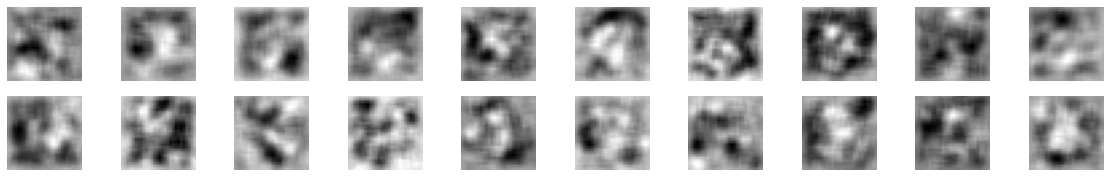

Epoch : 0, Iteration : 100


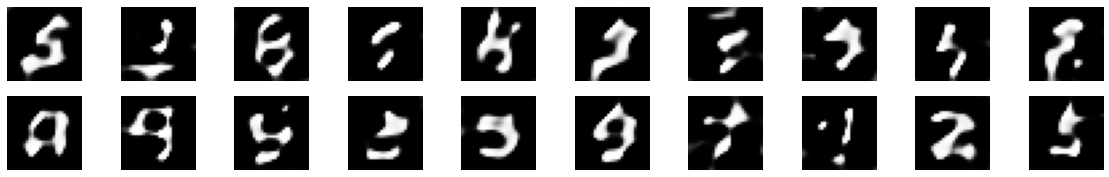

Epoch : 0, Iteration : 200


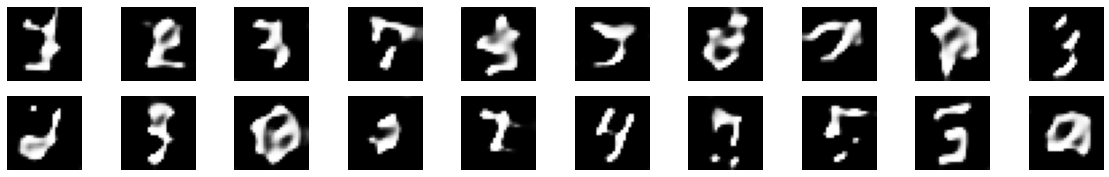

Epoch : 0, Iteration : 300


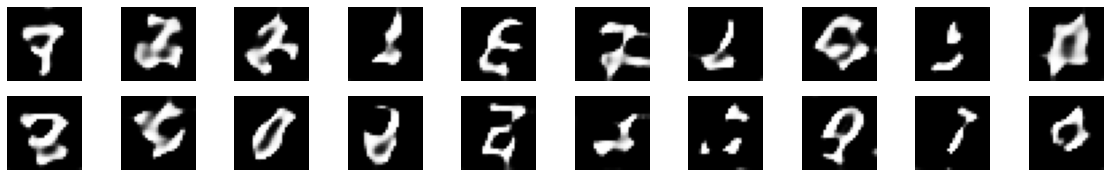

Epoch : 0, Iteration : 400


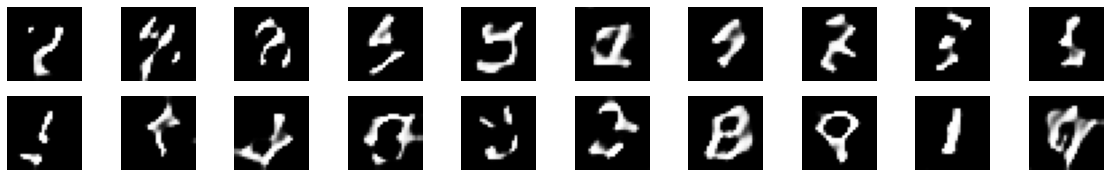

Epoch : 0, Iteration : 500


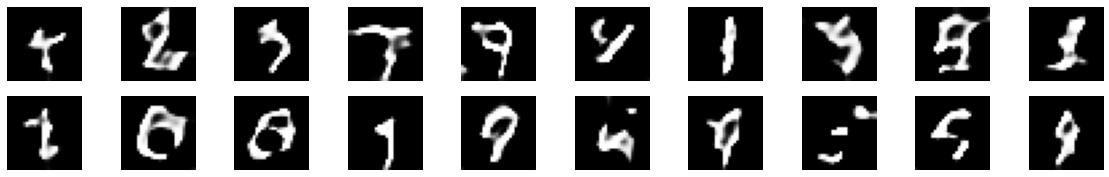


Epoch 0: loss = 0.00088202953;  time = 603.1325254440308


Epoch : 1, Iteration : 0


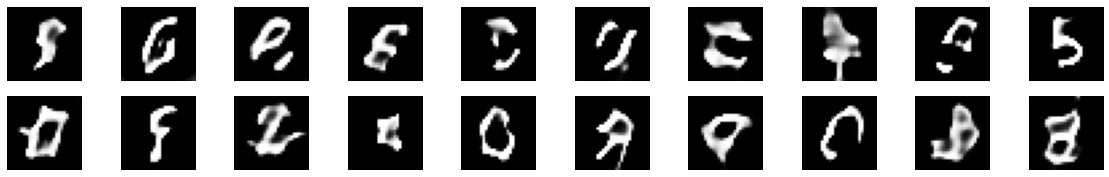

Epoch : 1, Iteration : 100


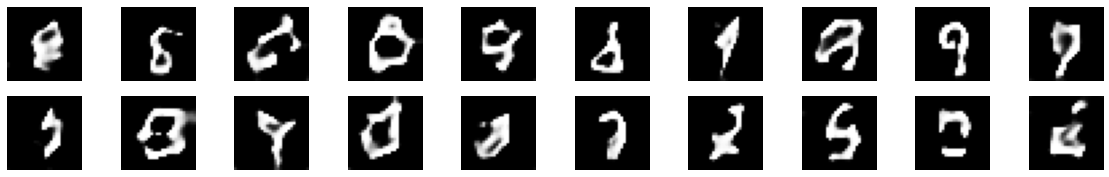

Epoch : 1, Iteration : 200


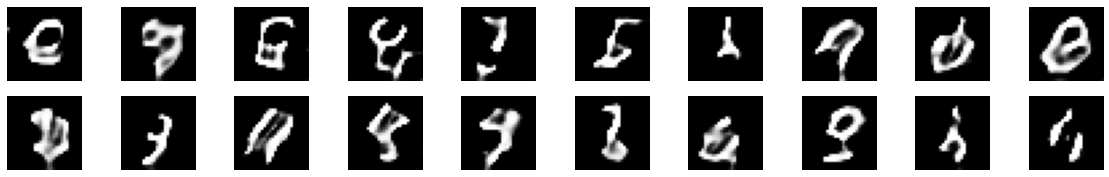

Epoch : 1, Iteration : 300


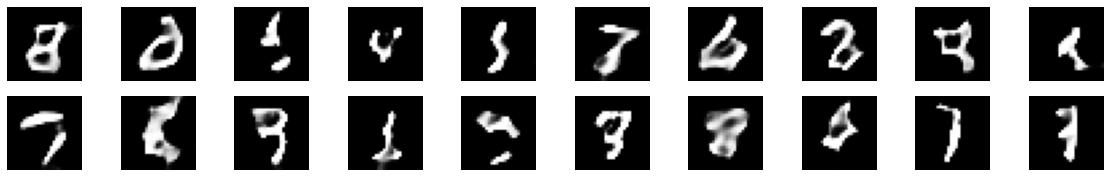

Epoch : 1, Iteration : 400


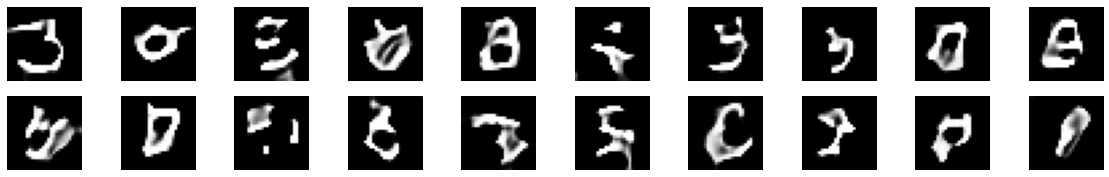

Epoch : 1, Iteration : 500


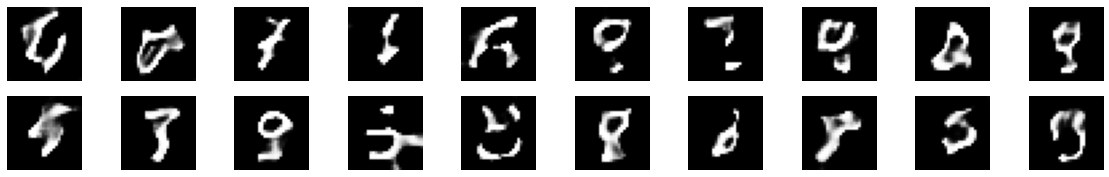


Epoch 1: loss = 0.0008047521;  time = 603.0575604438782


Epoch : 2, Iteration : 0


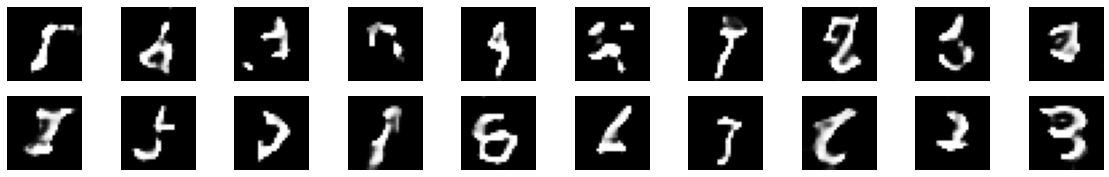

Epoch : 2, Iteration : 100


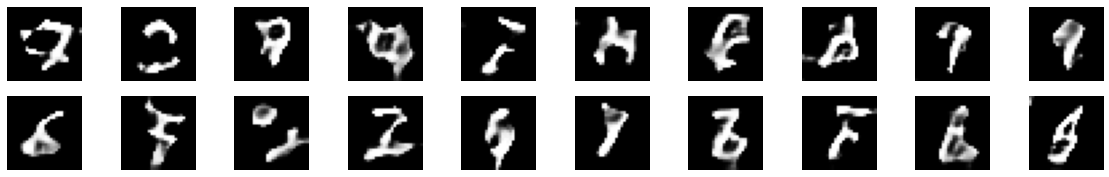

Epoch : 2, Iteration : 200


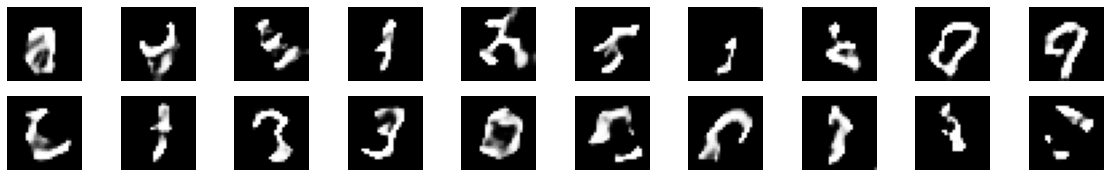

Epoch : 2, Iteration : 300


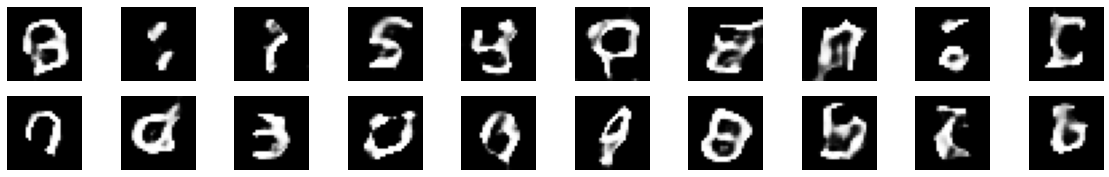

Epoch : 2, Iteration : 400


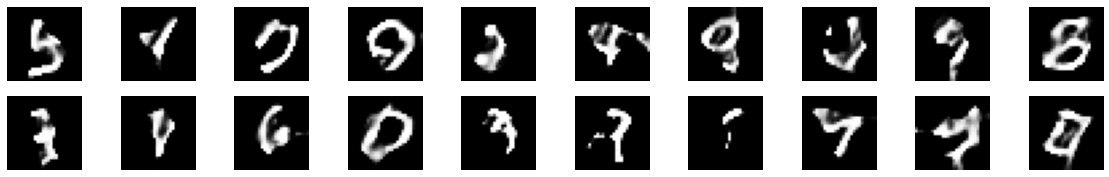

Epoch : 2, Iteration : 500


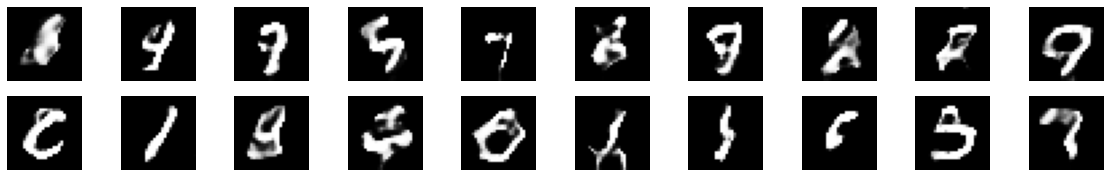


Epoch 2: loss = 0.00019958615;  time = 602.8196365833282


Epoch : 3, Iteration : 0


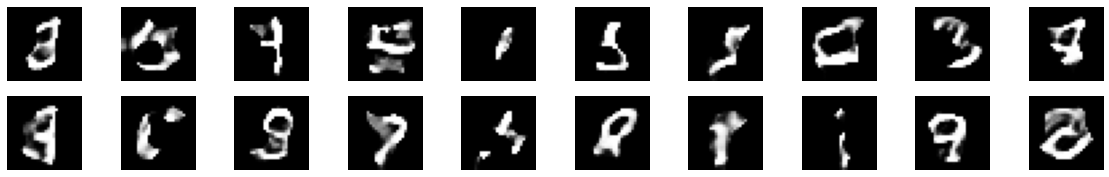

Epoch : 3, Iteration : 100


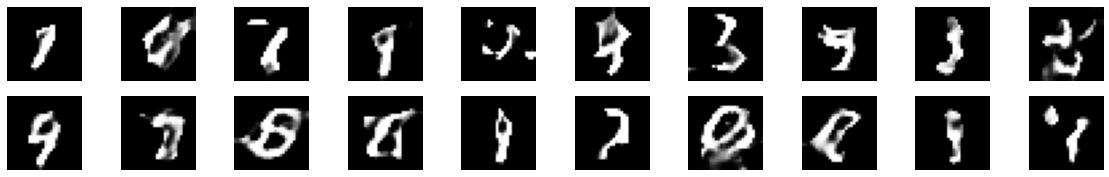

Epoch : 3, Iteration : 200


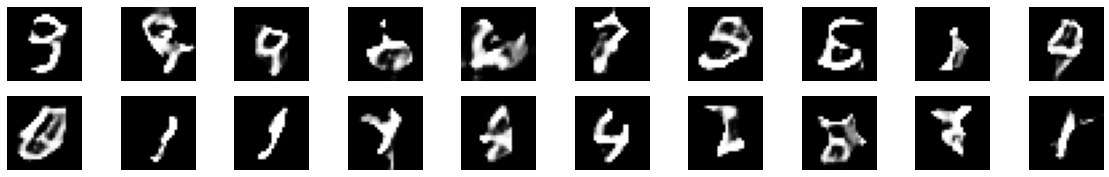

Epoch : 3, Iteration : 300


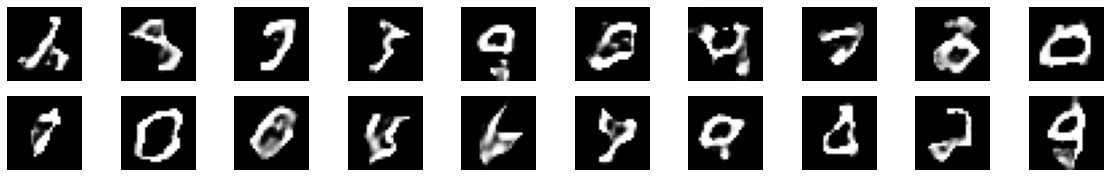

Epoch : 3, Iteration : 400


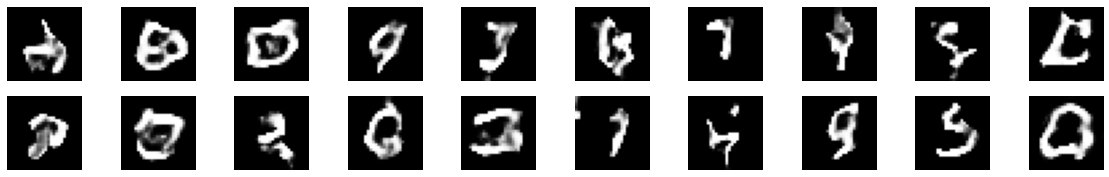

Epoch : 3, Iteration : 500


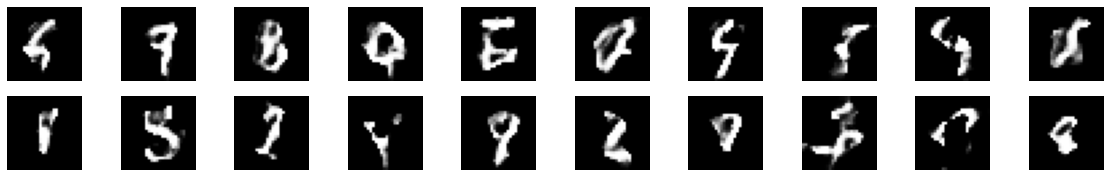


Epoch 3: loss = 0.002456218;  time = 603.3697650432587


Epoch : 4, Iteration : 0


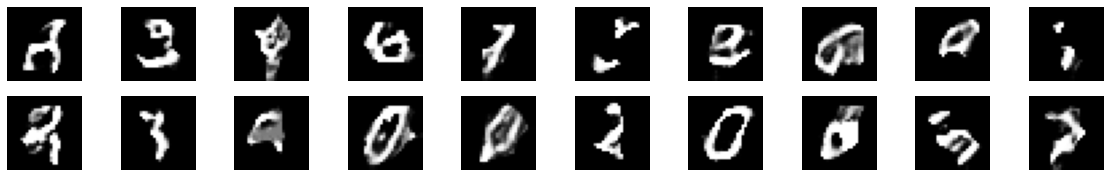

Epoch : 4, Iteration : 100


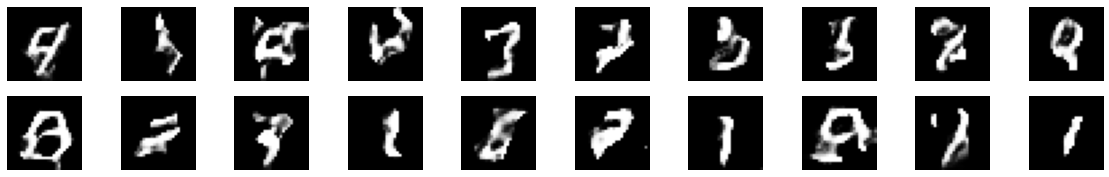

Epoch : 4, Iteration : 200


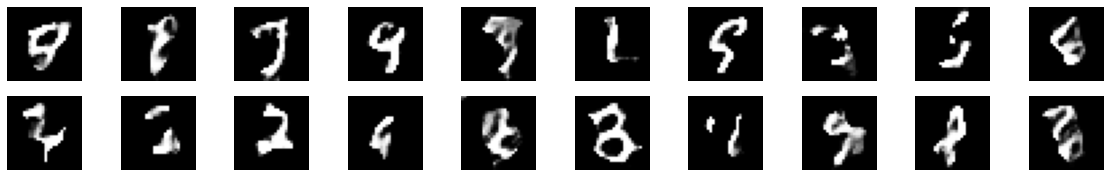

Epoch : 4, Iteration : 300


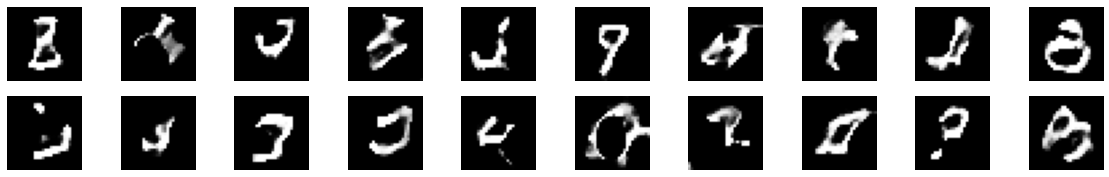

Epoch : 4, Iteration : 400


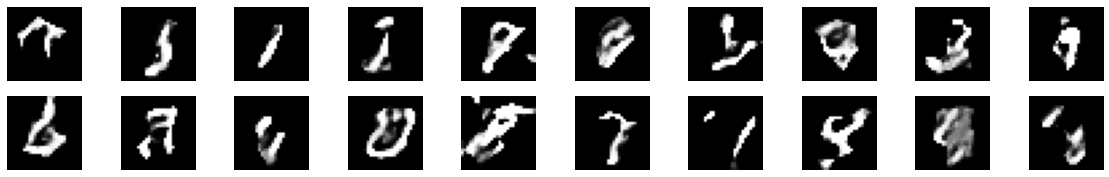

Epoch : 4, Iteration : 500


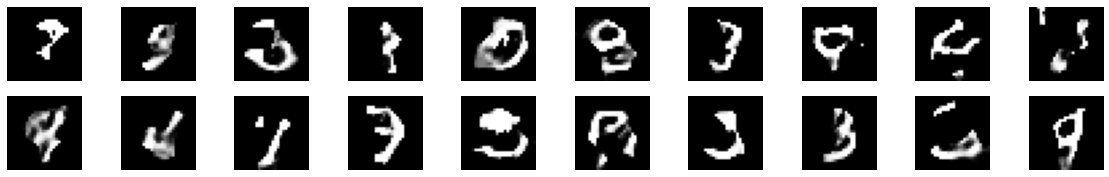


Epoch 4: loss = 0.0010436177;  time = 602.5895435810089


Epoch : 5, Iteration : 0


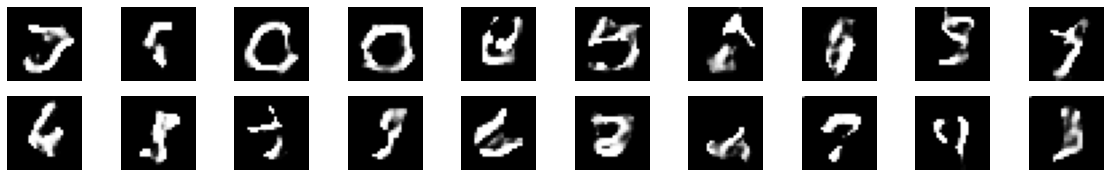

Epoch : 5, Iteration : 100


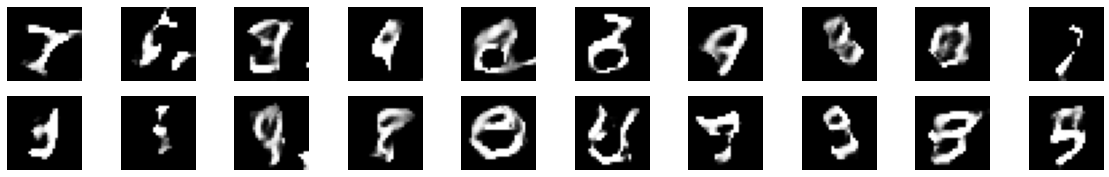

Epoch : 5, Iteration : 200


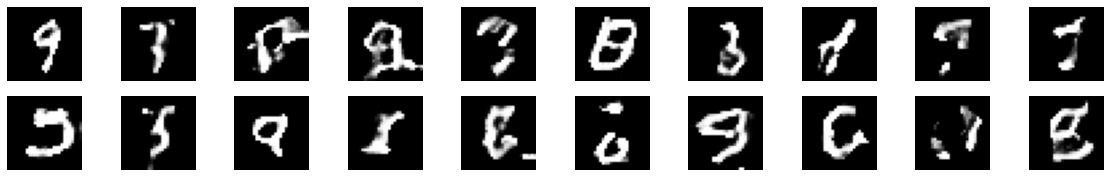

Epoch : 5, Iteration : 300


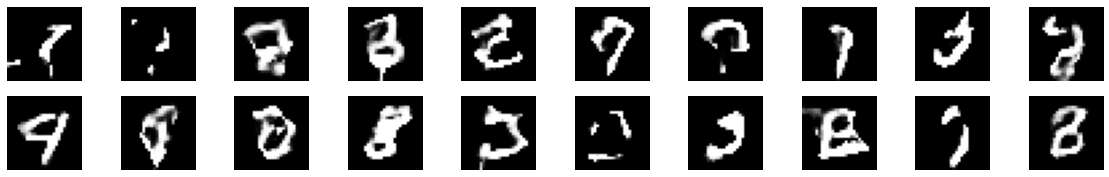

Epoch : 5, Iteration : 400


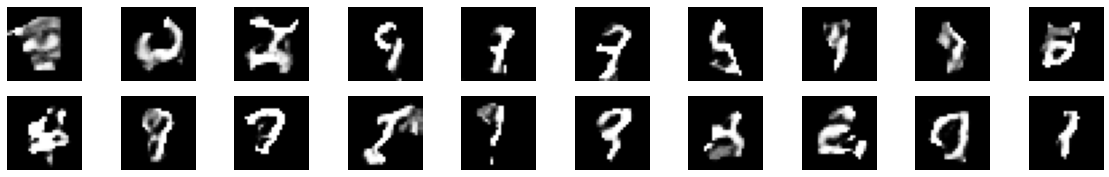

Epoch : 5, Iteration : 500


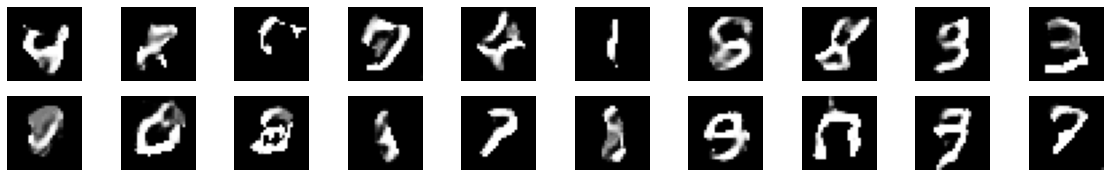


Epoch 5: loss = -0.00044715405;  time = 602.9414641857147


Epoch : 6, Iteration : 0


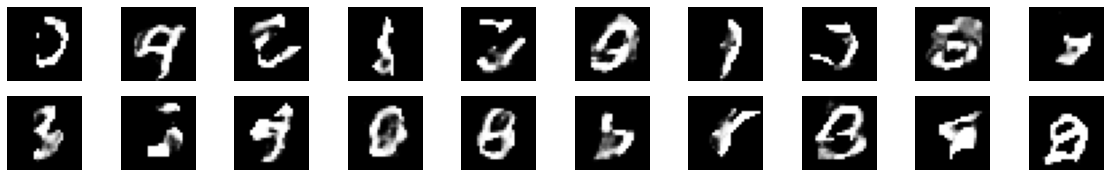

Epoch : 6, Iteration : 100


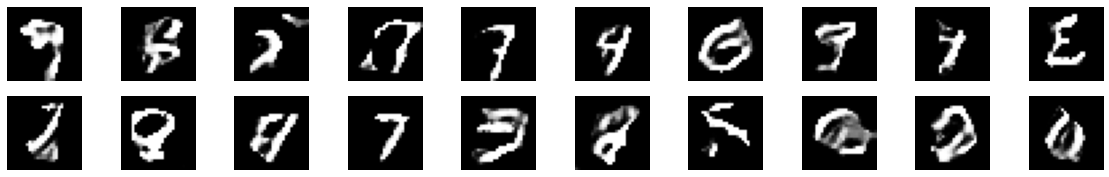

Epoch : 6, Iteration : 200


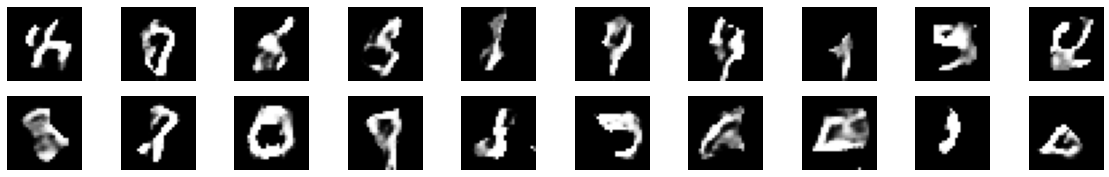

Epoch : 6, Iteration : 300


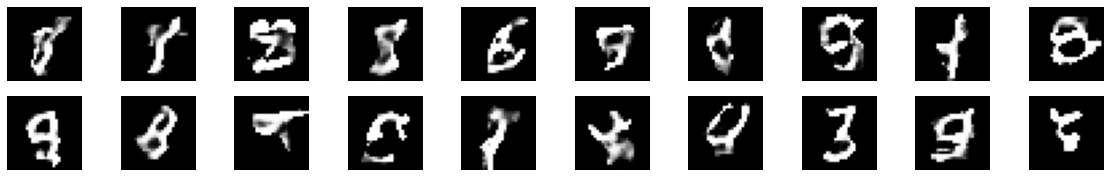

Epoch : 6, Iteration : 400


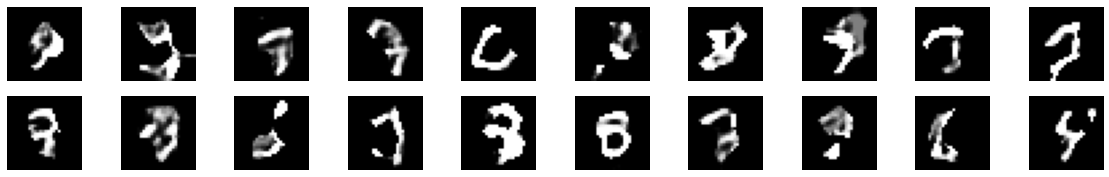

Epoch : 6, Iteration : 500


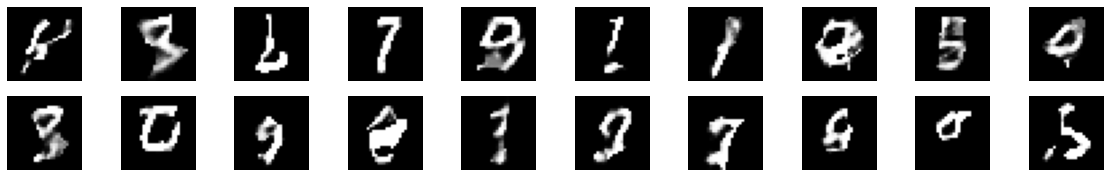


Epoch 6: loss = -0.00044581294;  time = 602.7117176055908


Epoch : 7, Iteration : 0


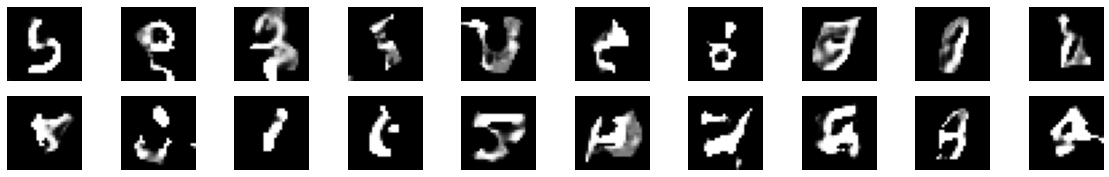

Epoch : 7, Iteration : 100


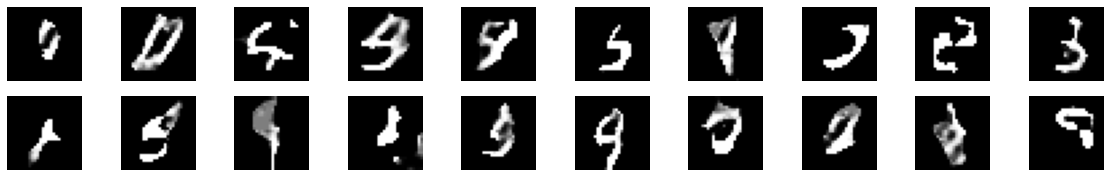

Epoch : 7, Iteration : 200


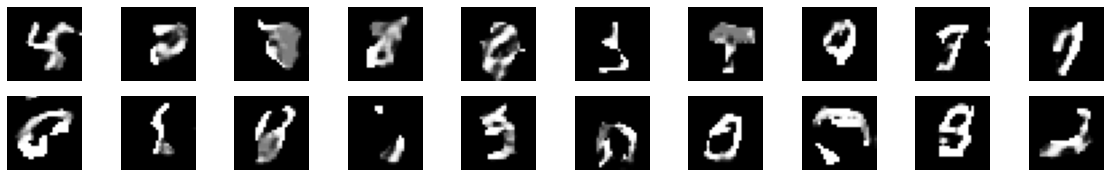

Epoch : 7, Iteration : 300


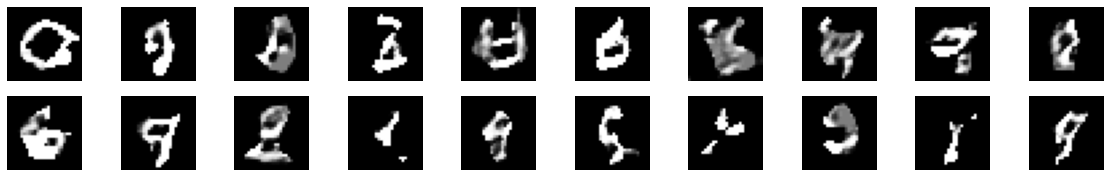

Epoch : 7, Iteration : 400


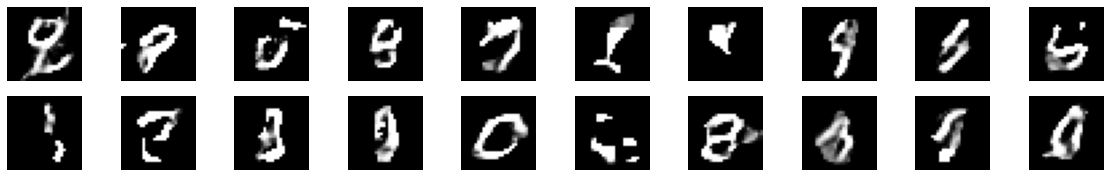

Epoch : 7, Iteration : 500


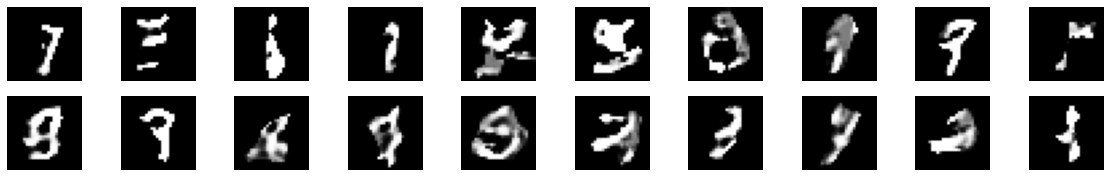


Epoch 7: loss = 0.0007299185;  time = 601.7735326290131


Epoch : 8, Iteration : 0


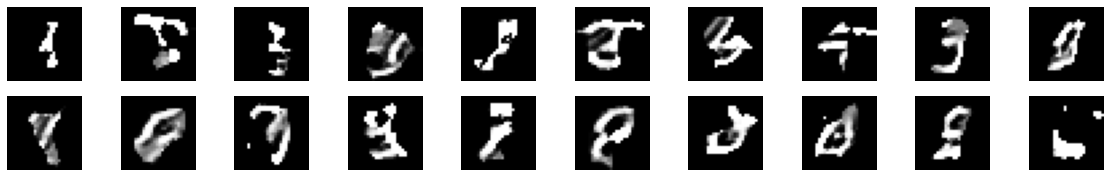

Epoch : 8, Iteration : 100


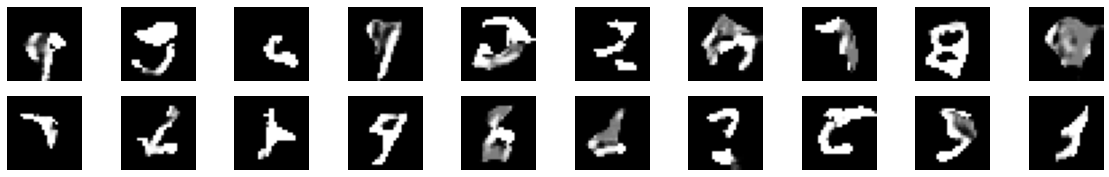

Epoch : 8, Iteration : 200


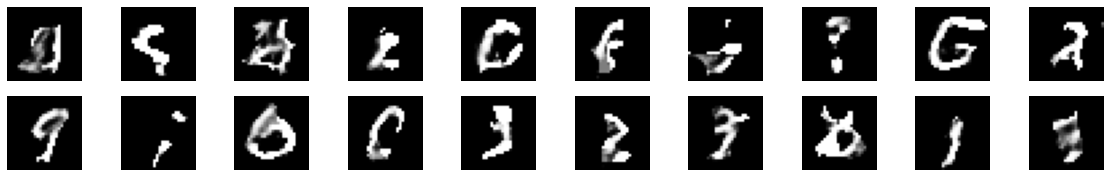

Epoch : 8, Iteration : 300


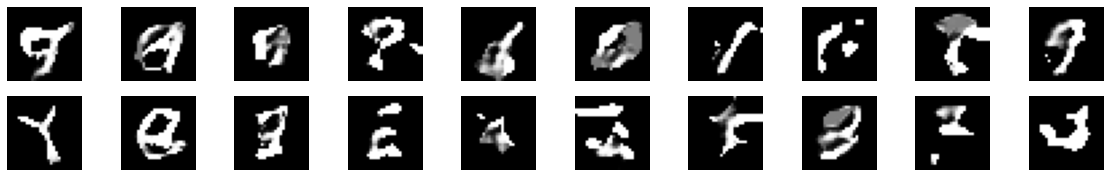

Epoch : 8, Iteration : 400


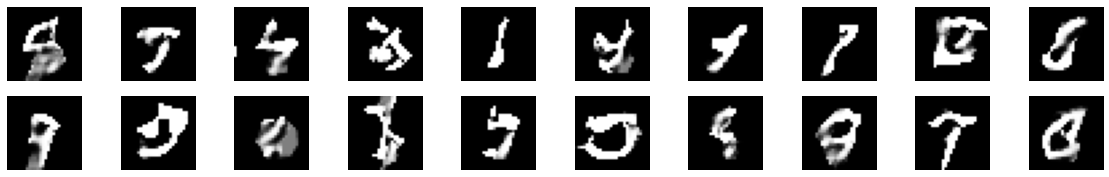

Epoch : 8, Iteration : 500


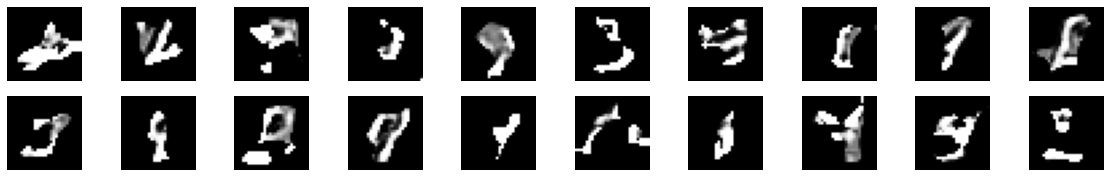


Epoch 8: loss = 0.0018081963;  time = 602.18101811409


Epoch : 9, Iteration : 0


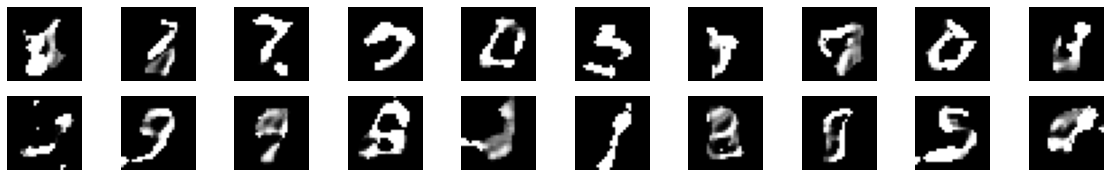

Epoch : 9, Iteration : 100


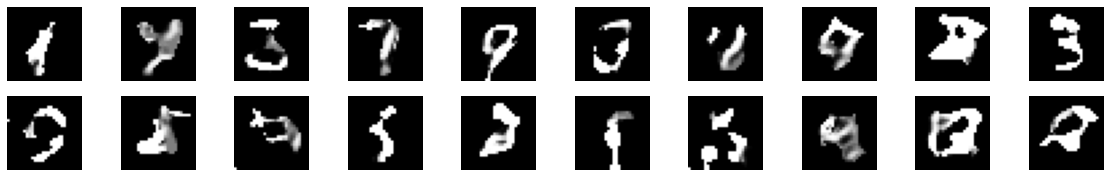

Epoch : 9, Iteration : 200


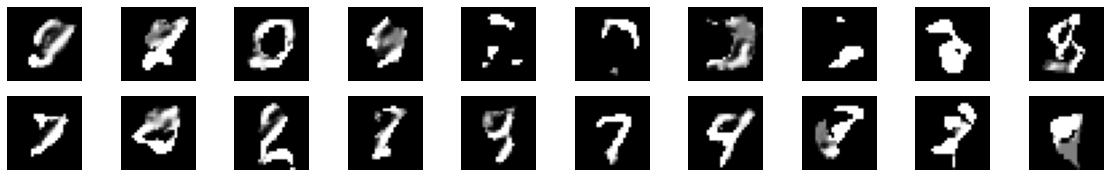

Epoch : 9, Iteration : 300


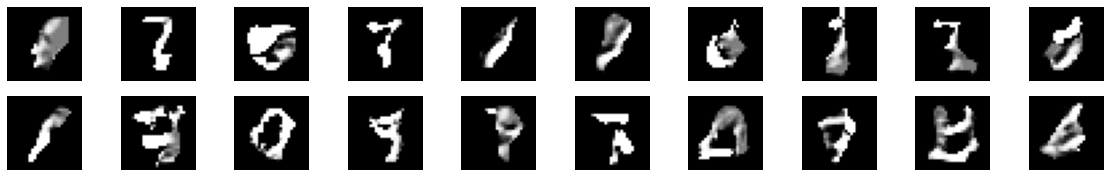

Epoch : 9, Iteration : 400


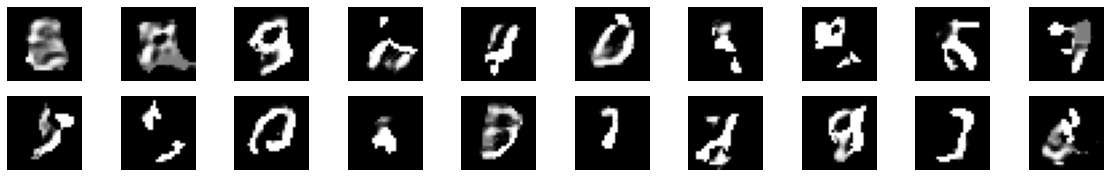

Epoch : 9, Iteration : 500


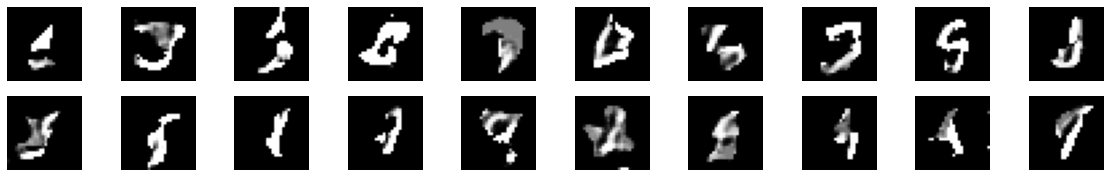


Epoch 9: loss = -0.0002876222;  time = 602.1123046875


Epoch : 10, Iteration : 0


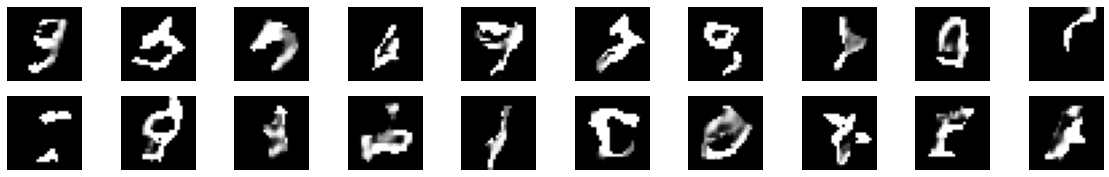

Epoch : 10, Iteration : 100


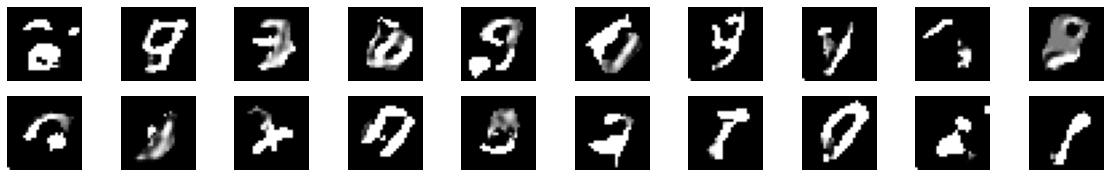

Epoch : 10, Iteration : 200


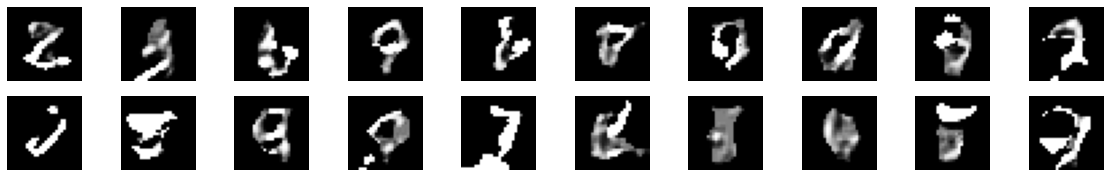

Epoch : 10, Iteration : 300


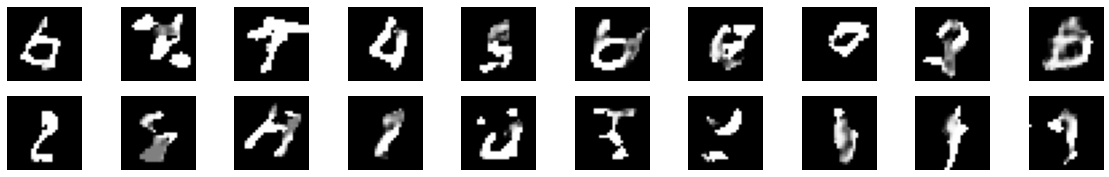

Epoch : 10, Iteration : 400


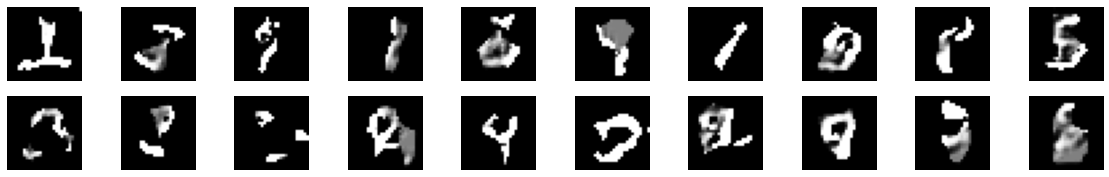

Epoch : 10, Iteration : 500


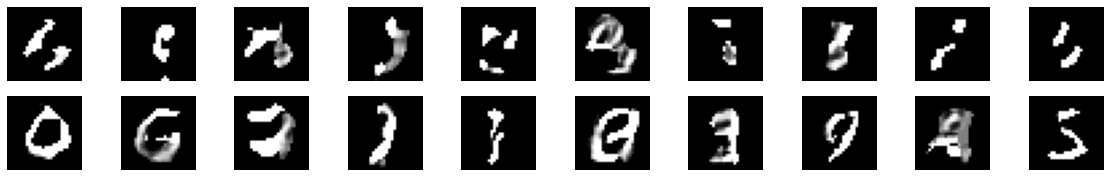


Epoch 10: loss = 0.00024232268;  time = 601.4616816043854


In [ ]:
batch_size = 100
latent_dim = 100
n_epochs = 10

otgan_generator = OT_Generator(input_size=latent_dim)
otgan_discriminator = OT_Discriminator()

otgan = OTGAN(otgan_generator, otgan_discriminator, latent_dim)
otgan.train(x_train, batch_size=batch_size, n_epochs=n_epochs)